In [ ]:
pip install sentinelsat rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 819.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for html2text: filename=html2text-2024.2.26-py3-none-any.whl size=33111 sha256=7e667135f09ac9567b83196996efa8eb39426aba10209edc3dd738ec30125991
  Stored in directory: /root/.cache/pip/wheels/f3/96/6d/a7eba8f80d31cbd188a2787b81514d82fc5ae6943c44777659
Successfully built html2text


Accuracy : 1.0
Enter the number of unknown images: 2
Enter URL for unknown image 1: https://eoimages.gsfc.nasa.gov/images/imagerecords/152000/152108/somaliafloodingzm_oli_2023255.jpg
Enter URL for unknown image 2: https://ichef.bbci.co.uk/news/800/cpsprodpb/5D27/production/_131974832_1_after_20231009_035134_07_24b6_3b_visual_clip.png.webp
Predictions for Unknown Images:
Image URL: https://eoimages.gsfc.nasa.gov/images/imagerecords/152000/152108/somaliafloodingzm_oli_2023255.jpg, Predicted Class: Non-Flood
Image URL: https://ichef.bbci.co.uk/news/800/cpsprodpb/5D27/production/_131974832_1_after_20231009_035134_07_24b6_3b_visual_clip.png.webp, Predicted Class: Flood


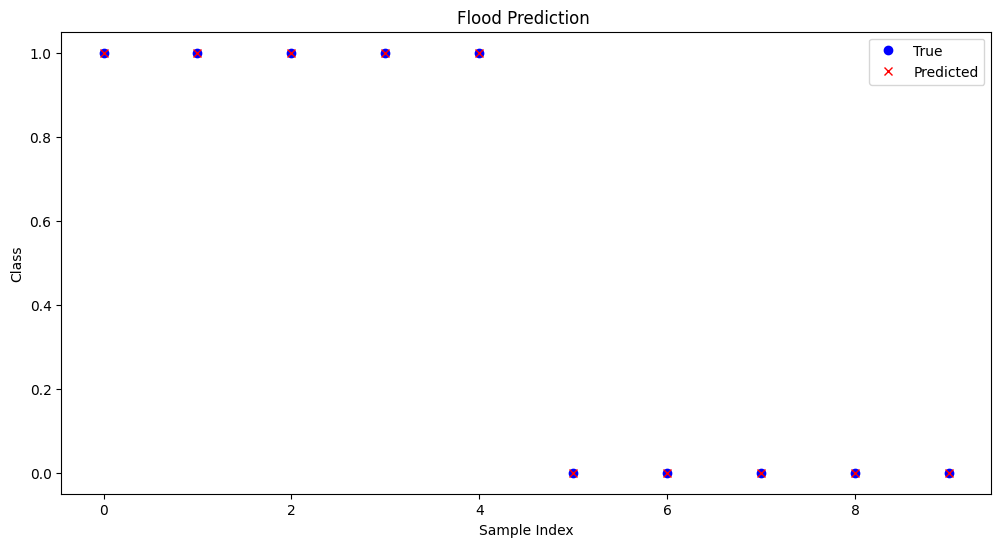

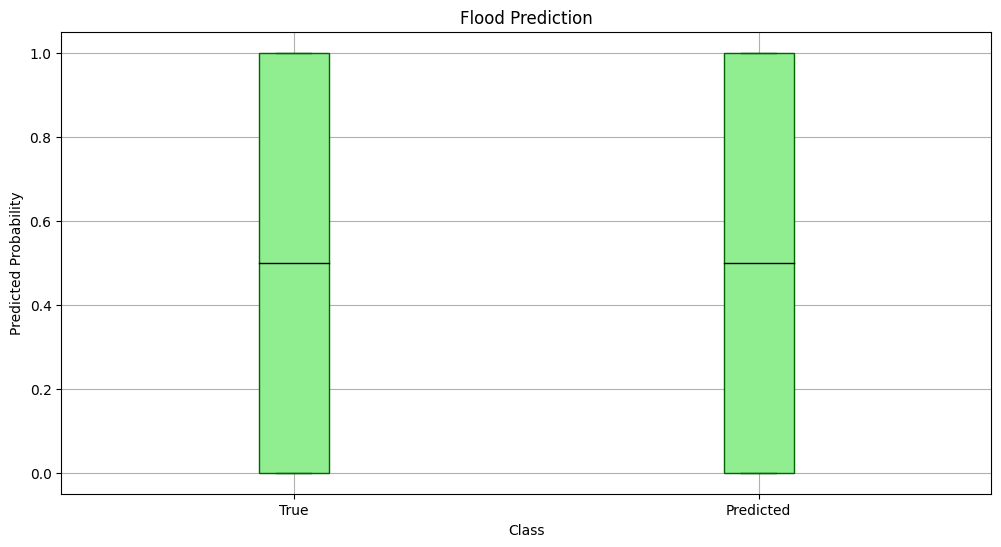

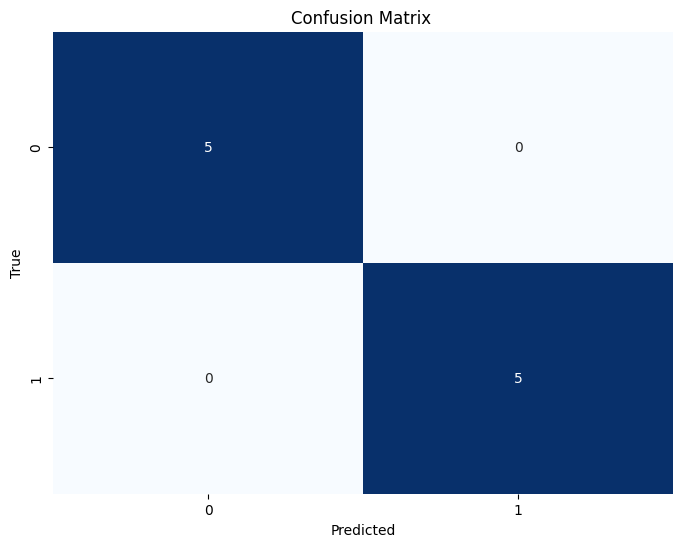

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from skimage import color, transform
import seaborn as sns

# Function to download and preprocess the image
def preprocess_image(url):
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content)).convert("RGB")
        img = img.resize((100, 100))  # Resize the image for consistency
        img = np.array(img)
        # Convert to grayscale and flatten
        img_gray = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140]).flatten()
        # Use color channels as well
        img_color = img.flatten()
        return np.concatenate([img_gray, img_color])  # Concatenate grayscale and color channels
    except Exception as e:
        print(f"Error processing image from URL: {url}. Skipping...")
        return None

# Sample URLs of flood and non-flood images
flood_urls = [
    'https://eoimages.gsfc.nasa.gov/images/imagerecords/152000/152153/riograndedosul_oli_2023325_lrg.jpg',
    'https://eoimages.gsfc.nasa.gov/images/imagerecords/152000/152295/ukflooding_oli2_20240104_lrg.jpg',
    'https://eoimages.gsfc.nasa.gov/images/imagerecords/152000/152051/italyflooding_oil_2023307_lrg.jpg',
    'https://eoimages.gsfc.nasa.gov/images/imagerecords/151000/151754/sutlejriverflooding_oli2_2023231_lrg.jpg',
    'https://eoimages.gsfc.nasa.gov/images/imagerecords/150000/150814/waflooding_amo_2023009_lrg.jpg'
    # Add more flood image URLs here
]

non_flood_urls = [
    'https://eoimages.gsfc.nasa.gov/images/imagerecords/152000/152153/riograndedosul_oli_2023309_lrg.jpg',
    'https://eoimages.gsfc.nasa.gov/images/imagerecords/152000/152295/ukflooding_oli2_20220105_lrg.jpg',
    'https://eoimages.gsfc.nasa.gov/images/imagerecords/152000/152051/italyflooding_oil_2023275.jpg',
    'https://eoimages.gsfc.nasa.gov/images/imagerecords/151000/151754/sutlejriverflooding_oli2_2023167_lrg.jpg',
    'https://eoimages.gsfc.nasa.gov/images/imagerecords/150000/150814/waflooding_amo_2022351_lrg.jpg'
    # Add more non-flood image URLs here
]

# Combine known flood and non-flood data
X_known = np.array([preprocess_image(url) for url in flood_urls + non_flood_urls if preprocess_image(url) is not None])
y_known = np.array([1] * len(flood_urls) + [0] * len(non_flood_urls))

# Train a Random Forest classifier on the known dataset
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_known, y_known)

# Calculate overall accuracy for known data
known_accuracy = accuracy_score(y_known, clf.predict(X_known))
print("Accuracy :", known_accuracy)

# Ask for URLs for prediction from the user
unknown_urls = []
num_unknown_images = int(input("Enter the number of unknown images: "))
for i in range(num_unknown_images):
    url = input(f"Enter URL for unknown image {i+1}: ")
    unknown_urls.append(url)

# Function to predict unknown images
def predict_unknown_images(urls):
    X_unknown = np.array([preprocess_image(url) for url in urls if preprocess_image(url) is not None])
    return clf.predict(X_unknown)

# Predictions for unknown images
y_unknown_pred = predict_unknown_images(unknown_urls)

# Display predictions for unknown images
print("Predictions for Unknown Images:")
for url, prediction in zip(unknown_urls, y_unknown_pred):
    print(f"Image URL: {url}, Predicted Class: {'Flood' if prediction == 1 else 'Non-Flood'}")


# Plot predictions for known data
plt.figure(figsize=(12, 6))
plt.plot(y_known, 'bo', label='True')
plt.plot(clf.predict(X_known), 'rx', label='Predicted')
plt.title('Flood Prediction ')
plt.xlabel('Sample Index')
plt.ylabel('Class')
plt.legend()
plt.show()

# Plot predictions for known data (Box plot)
plt.figure(figsize=(12, 6))
plt.boxplot([y_known, clf.predict(X_known)], labels=['True', 'Predicted'], patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='darkgreen'),
            whiskerprops=dict(color='darkgreen'),
            capprops=dict(color='darkgreen'),
            medianprops=dict(color='black'))
plt.title('Flood Prediction')
plt.xlabel('Class')
plt.ylabel('Predicted Probability')
plt.grid(True)
plt.show()

# Plot confusion matrix for known data
plt.figure(figsize=(8, 6))
cm_known = confusion_matrix(y_known, clf.predict(X_known))
sns.heatmap(cm_known, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Enter the number of unknown images: 2

Enter URL for unknown image 1: https://eoimages.gsfc.nasa.gov/images/imagerecords/152000/152108/somaliafloodingzm_oli_2023255.jpg


Enter URL for unknown image 2: https://ichef.bbci.co.uk/news/800/cpsprodpb/5D27/production/_131974832_1_after_20231009_035134_07_24b6_3b_visual_clip.png.webp


Predictions for Unknown Images: Image URL: https://eoimages.gsfc.nasa.gov/images/imagerecords/152000/152108/somaliafloodingzm_oli_2023255.jpg,

Predicted Class: Non-Flood
Image URL: https://ichef.bbci.co.uk/news/800/cpsprodpb/5D27/production/_131974832_1_after_20231009_035134_07_24b6_3b_visual_clip.png.webp,

Predicted Class: Flood